Final Project：LSTM

In [30]:
# 連接至Colab，可能需要協助更改路徑
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/
%cd "/content/drive/My Drive" 
%cd "1101/DL/Final"

%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MyDrive  Shareddrives
/content/drive/My Drive
/content/drive/My Drive/1101/DL/Final
 0111LSTM_epochs_10_batch_128_Adam_lr_0.003/          Untitled1.ipynb
 0111LSTM_epochs_50_batch_128_Adam_lr_0.003/          Untitled2.ipynb
 0111LSTM_epochs_5_batch_128_Adam_lr_0.003/           v10/
 0115LSTM_epochs_50_batch_128_Adam_lr_0.003/          v3/
 0116LSTM_epochs_50_batch_64_Adam_lr_0.003/           v4/
 0120LSTM_epochs_10_batch_128_Adam_lr_0.003/          v5/
 0120LSTM_epochs_50_batch_128_Adam_lr_0.003/          v6/
 0121LSTM1v3_epochs_10_batch_128_Adam_lr_0.003/       v7/
 d51_0120LSTM1v4_epochs_10_batch_128_Adam_lr_0.003/   v8/
 d51_0120LSTM3v3_epochs_10_batch_128_Adam_lr_0.003/   x_test1.csv
 d51_0120LSTM3v3_epochs_30_batch_128_Adam_lr_0.003/   x_test.csv
'lstm (1).ipynb'                                      x_train1.csv
 LSTM.ipynb                               

In [31]:
!nvidia-smi
from google.colab import drive
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import argparse
import time
import os

Fri Jan 21 07:23:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    74W / 149W |   4418MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
# 匯出成csv
def output(filepath, data):
    df_SAMPLE = pd.DataFrame.from_dict(data)
    df_SAMPLE.to_csv(filepath, index=False)
    print('Success output to ' + filepath)

# RMSE 評估值
def RMSE(y_pred, y_true):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

Argparse: 可更改參數及DIR路徑名稱

In [33]:
# argparse
parser = argparse.ArgumentParser(description='Final Project')
parser.add_argument('--epochs', default='100', type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default='32', type=int,
                    metavar='N',
                    help='mini-batch size (default: 32), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--opt', type=str, default='SGD',
                        help='SGD or Adam (default: SGD)')
parser.add_argument('--lr', '--learning-rate', default='0.1', type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('--save', default='', type=str, metavar='PATH',
                    help='path to latest dir (default: none)')
parser.add_argument('--p', '--predict', dest='predict', action='store_true',
                    help='evaluate model on test set')

# today = dt.now()

# SGD Setting
# args = parser.parse_args(args=['--epochs', '50', '--batch-size', '64', '--opt', 'SGD', '--lr', '0.001', '--resume', './workspace/my_model.h5', '--save', '.'])
# predict
# args = parser.parse_args(args=['--epochs', '50', '--batch-size', '64', '--opt', 'SGD', '--lr', '0.001', '--resume', './workspace/my_model.h5', '--save', '.','--p'])
# Adam Setting
args = parser.parse_args(args=['--epochs', '10', '--batch-size', '128', '--opt', 'Adam', '--lr', '0.003', '--resume', './workspace/my_model.h5', '--save', '.'])
# predict
# args = parser.parse_args(args=['--epochs', '30', '--batch-size', '64', '--opt', 'Adam', '--lr', '0.0001', '--resume', './workspace/my_model.h5', '--save', '.','--p'])
DIR =  './0121LSTM1v3_epochs_' + str(args.epochs) + '_batch_' + str(args.batch_size) + '_' + str(args.opt) + '_lr_' + str(args.lr)

if not os.path.exists(DIR+'/logs/'):
    os.makedirs(DIR+'/logs/')
if not os.path.exists(DIR+'/result/'):
    os.makedirs(DIR+'/result/')
if not os.path.exists(DIR+'/workspace/'):
    os.makedirs(DIR+'/workspace/')
    
with open(DIR+'/logs/args.txt', 'w') as f:
    f.write(str(args))

Load data: 可更改讀取資料集，'vk/x_traink.csv'，k=3~10

In [34]:
# 更改成想測試的version
# 部分version的data需要以ID為依據重新sort
x_train = pd.read_csv('v4/x_train4.csv', header=0, low_memory=False)
#x_train = x_train.sort_values(by=['ID'])
y_train = pd.read_csv('v4/y_train4.csv', header=0, low_memory=False)
#y_train = y_train.sort_values(by=['ID'])
x_test = pd.read_csv('v4/x_test4.csv', header=0, low_memory=False)
#x_test = x_test.sort_values(by=['ID'])
y_test = pd.read_csv('v4/y_test4.csv', header=0, low_memory=False)
#y_test = y_test.sort_values(by=['ID'])
print('x_train.shape= {}, y_train.shape= {}'.format(x_train.shape, y_train.shape))
print('x_test.shape= {}, y_test.shape= {}'.format(x_test.shape, y_test.shape))

x_train.set_index('ID', inplace=True)
y_train.set_index('ID', inplace=True)
x_test.set_index('ID', inplace=True)
y_test.set_index('ID', inplace=True)

print('x_train.shape= {}, y_train.shape= {}'.format(x_train.shape, y_train.shape))
print('x_test.shape= {}, y_test.shape= {}'.format(x_test.shape, y_test.shape))

x_train.shape= (33254, 4012), y_train.shape= (33254, 2)
x_test.shape= (4263, 4012), y_test.shape= (4263, 2)
x_train.shape= (33254, 4011), y_train.shape= (33254, 1)
x_test.shape= (4263, 4011), y_test.shape= (4263, 1)


Train: 

三個不同mode，皆為One to One LSTM

1. buildOneLayerModel
2. buildTwoLayerModel
3. buildThreeLayerModel

In [35]:
# train
if args.opt == 'Adam':
    optim = Adam(learning_rate=args.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-5)
elif args.opt == 'SGD':
    optim = SGD(learning_rate=args.lr)
else:
    optim = None

def buildTrain(x_data, y_data):
  x_train, y_train = [], []
  for i in range(x_data.shape[0]):
    x_train.append(np.array(x_data.iloc[i]))
    y_train.append(np.array(y_data.iloc[i]["乳量"]))
  return np.array(x_train), np.array(y_train)

# One layer one to one LSTM
def buildOneLayerModel(shape):
  model = Sequential()
  model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.5, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  model.add(Dense(1))   # or use model.add(TimeDistributed(Dense(1)))
  model.compile(loss=RMSE, optimizer=optim, metrics=[RMSE])
  model.summary()
  return model

# Two layer one to one LSTM
def buildTwoLayerModel(shape):
  model = Sequential()
  model.add(LSTM(2046, dropout=0.1, recurrent_dropout=0.5, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
  model.add(Dense(1))   # or use model.add(TimeDistributed(Dense(1)))
  model.compile(loss=RMSE, optimizer=optim, metrics=[RMSE])
  model.summary()
  return model

# Three layer one to one LSTM
def buildThreeLayerModel(shape):
  model = Sequential()
  model.add(LSTM(2046, dropout=0.1, recurrent_dropout=0.5, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
  model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
  model.add(Dense(1))   # or use model.add(TimeDistributed(Dense(1)))
  model.compile(loss=RMSE, optimizer=optim, metrics=[RMSE])
  model.summary()
  return model

Start train: 可更改成想使用的Model

(33254, 1, 4011)
(4263, 1, 4011)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 512)            9265152   
                                                                 
 dense_3 (Dense)             (None, 1, 1)              513       
                                                                 
Total params: 9,265,665
Trainable params: 9,265,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
259/259 [==============================] - 8s 20ms/step - loss: 8.4808 - RMSE: 8.4757 - val_loss: 3.8825 - val_RMSE: 3.6705
Epoch 2/10
259/259 [==============================] - 5s 18ms/step - loss: 5.5603 - RMSE: 5.5612 - val_loss: 3.5714 - val_RMSE: 3.4952
Epoch 3/10
259/259 [==============================] - 5s 18ms/step - loss: 5.1640 - RMSE: 5.1656 - val_loss: 3.7821 - val_RMSE: 3.4823
Ep

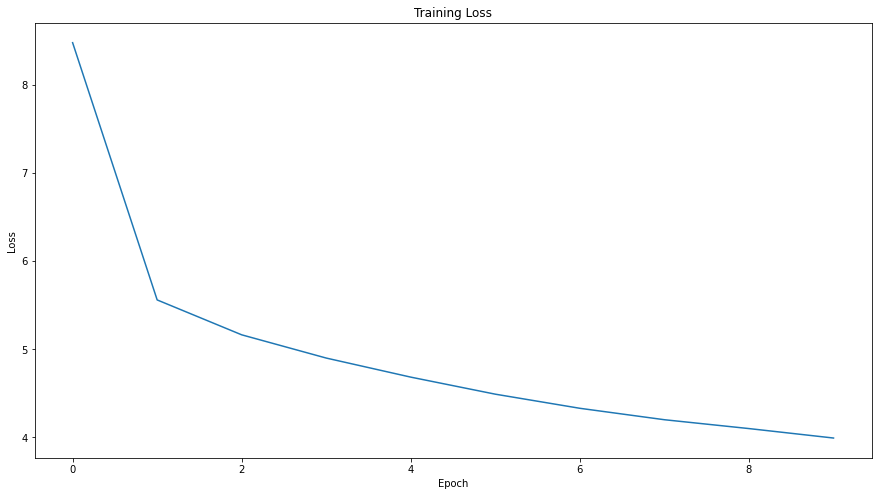

In [36]:
x_train = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
y_train = y_train.values.reshape((y_train.shape[0], 1, y_train.shape[1]))
x_test = x_test.values.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape)
print(x_test.shape)

# from 2 dimmension to 3 dimension
y_train = y_train[:,np.newaxis]


model = buildOneLayerModel(x_train.shape) ######### 可更改成想使用的Model
#model = buildTwoLayerModel(x_train.shape)
#model = buildThreeLayerModel(x_train.shape)

callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.batch_size, validation_split=0.005, callbacks=[callback])
#model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.batch_size, validation_split=0.05, callbacks=[callback])
result = model.predict(x_test)
result = model.predict(x_test)
print(result.shape)


y_test['乳量'] = result[:,0,:]
y_test.reset_index(inplace=True)
y_test = y_test.sort_values(by='ID')

y_test.reset_index(inplace=True)
y_test = y_test.drop('index', axis=1)
#y_test = y_test.drop('level_0', axis=1)

print(y_test.head(n=3))
output('result/lstm.csv', y_test)

print(history.history.keys())
fig=plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
fig.savefig(DIR+'/result/loss.png',format='png')